In [1]:
import pickle
import threading
from time import sleep
from copy import deepcopy
from queue import Queue, Empty

import pyuarm
import theano
from theano import tensor
import numpy as np
from scipy.spatial.distance import euclidean
from pyuarm.protocol import SERVO_BOTTOM, SERVO_LEFT, SERVO_RIGHT, SERVO_HAND
import matplotlib.pyplot as plt
from scipy.stats import linregress

SERVOS = [SERVO_BOTTOM, SERVO_LEFT, SERVO_RIGHT, SERVO_HAND]

def to_deg(rad):
    return 180 * rad / np.pi

def to_rad(deg):
    return np.pi * deg / 180.0

In [2]:
k1 = OF = 0.107
k2 = FA = 0.02
k3 = AB = 0.148
k4 = BC = 0.16
k5 = CE = 0.035
k6 = DE = 0.06

def forward(alpha, beta, gamma):
    r = k2 + k3 * np.cos(alpha) + k4 * np.cos(beta) + k5
    z = k1 + k3 * np.sin(alpha) + k4 * np.sin(beta) - k6
    return r * np.cos(gamma), r * np.sin(gamma), z

def inverse(x, y, z):
    # Polar coordinates, solve in vertical 2D plane
    gamma = np.arctan2(y, x)
    r = np.sqrt(x ** 2 + y ** 2) - k2 - k5
    # Calculate from first joint to end of forearm
    z_p = z - k1 + k6
    alpha_part = np.arctan2(z_p, r)
    # Rotate so triangle base joint, next joint, end of forearm "lies down"
    r_pp = r * np.cos(-alpha_part) - z_p * np.sin(-alpha_part)
    z_pp = r * np.sin(-alpha_part) + z_p * np.cos(-alpha_part)
    alpha_rest = np.arccos((k3 ** 2 + r_pp ** 2 - k4 ** 2) / (2 * k3 * r_pp))
    alpha = alpha_part + alpha_rest
    top_angle = np.arccos((k3 ** 2 - r_pp ** 2 + k4 ** 2) / (2 * k3 * k4))
    beta = np.arctan2(z_p - k3 * np.sin(alpha), r - k3 * np.cos(alpha))
    return alpha, beta, gamma
    
inverse(0, 0.2, 0.02)
forward(*inverse(0, 0.2, 0.02))

(1.2246467991473534e-17, 0.20000000000000004, 0.020000000000000018)

In [3]:
def detach_all():
    for s in SERVOS:
        arm.set_servo_detach(s)
        
def attach_all():
    for s in SERVOS:
        arm.set_servo_attach(s)

In [553]:
arm = pyuarm.get_uarm()

pyuarm - INFO - pyuarm version: 2.2.5.3
pyuarm - INFO - pyuarm version: 2.2.5.3
pyuarm - INFO - pyuarm version: 2.2.5.3
pyuarm - INFO - Connecting from port - /dev/cu.usbserial-AI04HYRU...
pyuarm - INFO - Connecting from port - /dev/cu.usbserial-AI04HYRU...
pyuarm - INFO - Connecting from port - /dev/cu.usbserial-AI04HYRU...
pyuarm - INFO - Connected...
pyuarm - INFO - Connected...
pyuarm - INFO - Connected...
pyuarm - INFO - Firmware Version: 2.2.1
pyuarm - INFO - Firmware Version: 2.2.1
pyuarm - INFO - Firmware Version: 2.2.1


In [932]:
UPDATE_FREQ = 128 # Hz

class Arm():
    
    def __init__(self, arm=None):
        self._target = None
        self._cancel_worker = False
        if arm is None:
            self._arm = pyuarm.get_uarm()
        else:
            self._arm = arm
        with open('uarm_params.pkl', 'rb') as f:
            self._uarm_params = pickle.load(f)
        self._queue = []
        self._worker_thread = threading.Thread(target=self._worker)
        self._worker_thread.start()
        
    def disconnect(self):
        self._arm.disconnect()
        
    def stop(self):
        self._cancel_worker = True
        
    def cartesian_to_servo_angles(self, x, y, z):
        alpha_ideal, beta_ideal, gamma_ideal = map(to_deg, inverse(x, y, z))
        ideal_real = self._uarm_params['ideal_real']
        return (
            ideal_real[SERVO_LEFT]['slope'] * alpha_ideal + ideal_real[SERVO_LEFT]['intercept'],
            ideal_real[SERVO_RIGHT]['slope'] * beta_ideal + ideal_real[SERVO_RIGHT]['intercept'],
            ideal_real[SERVO_BOTTOM]['slope'] * gamma_ideal + ideal_real[SERVO_BOTTOM]['intercept'],
        )
    
    def servo_angles_to_cartesian(self, alpha, beta, gamma):
        ideal_real = self._uarm_params['ideal_real']
        alpha_p = to_rad((alpha - ideal_real[SERVO_LEFT]['intercept']) / ideal_real[SERVO_LEFT]['slope'])
        beta_p = to_rad((beta - ideal_real[SERVO_RIGHT]['intercept']) / ideal_real[SERVO_RIGHT]['slope'])
        gamma_p = to_rad((gamma - ideal_real[SERVO_BOTTOM]['intercept']) / ideal_real[SERVO_BOTTOM]['slope'])
        return forward(alpha_p, beta_p, gamma_p)
    
    def servo_angles_to_command(self, alpha, beta, gamma):
        km = self._uarm_params['commanded_measured']
        return (
            (alpha - km[SERVO_LEFT]['intercept']) / km[SERVO_LEFT]['slope'],
            (beta - km[SERVO_RIGHT]['intercept']) / km[SERVO_RIGHT]['slope'],
            (gamma - km[SERVO_BOTTOM]['intercept']) / km[SERVO_BOTTOM]['slope'],
        )
    
    def set_angles_relative(self, d_alpha, d_beta, d_gamma):
        alpha, beta, gamma = self.servo_angles_to_command(
            self._arm.get_servo_angle(SERVO_LEFT),
            self._arm.get_servo_angle(SERVO_RIGHT),
            self._arm.get_servo_angle(SERVO_BOTTOM)
        )
        self._set_angles(alpha + d_alpha, beta + d_beta, gamma + d_gamma)
        
    def get_position(self):
        return self.servo_angles_to_cartesian(
            self._arm.get_servo_angle(SERVO_LEFT),
            self._arm.get_servo_angle(SERVO_RIGHT),
            self._arm.get_servo_angle(SERVO_BOTTOM),
        )
    
    def _set_angles(self, alpha, beta, gamma):
        self._arm.set_servo_angle(SERVO_LEFT, alpha)
        self._arm.set_servo_angle(SERVO_RIGHT, beta)
        self._arm.set_servo_angle(SERVO_BOTTOM, gamma)
        
    def _set_cartesian(self, x, y, z):
        a = self.cartesian_to_servo_angles(x, y, z)
        b = self.servo_angles_to_command(*a)
        self._set_angles(*b)
        
    def set_pump(on):
        self._arm.set_pump(on)
        
    def move_to(self, x, y, z, duration=None, velocity=None):
        """
        x, y, z : float
            meter
        duration : float
            seconds
        velocity : float
            m / s, ignored if duration is specified
        """
        # add extreme safety bounds here!
        
        if duration is None and velocity is None:
            self._set_cartesian(x, y, z)
            return
        
        if self._queue:
            self._queue = []
            sleep(0.5)
        
        a = np.array(self.get_position())
        b = np.array([x, y, z])
        distance = euclidean(a, b)
        if velocity is not None:
            duration = distance / velocity
            
        # invariant: we have a, b, and duration
        n_pieces = UPDATE_FREQ * duration
        for i in range(1, int(n_pieces + 1)):
            partial_dist = i * distance / n_pieces
            x = a + (b - a) * i / n_pieces
            self._queue.append((x[0], x[1], x[2]))
        return
    
    def _worker(self):
        while not self._cancel_worker:
            try:
                x, y, z = self._queue[0]
                self._queue = self._queue[1:]
                self._set_cartesian(x, y, z)
            except IndexError:
                pass
            sleep(1.0 / UPDATE_FREQ)
            
try:
    a.stop()
except:
    pass
a = Arm(arm=arm)
a.move_to(0.1, 0.25, 0.02, velocity=0.5)

In [823]:
print(a._uarm_params['ideal_real'][SERVO_RIGHT])
print(a._uarm_params['ideal_real'][SERVO_LEFT])

{'intercept': 21.688605081576, 'slope': -1.0613190063594546}
{'intercept': 62.053097015110282, 'slope': 1.1243501143845358}


In [933]:
a.get_position()

(0.1010144889510286, 0.29868680192653663, 0.00049177045401985198)

In [525]:
alpha, beta, gamma = a.servo_angles_to_command(
    a._arm.get_servo_angle(SERVO_LEFT),
    a._arm.get_servo_angle(SERVO_RIGHT),
    a._arm.get_servo_angle(SERVO_BOTTOM)
)
a._set_angles(alpha, beta + 4, gamma)

In [971]:
a.get_position()

(0.058008623596486827, 0.20448524168756119, 0.026883237755555345)

In [970]:
a.set_angles_relative(+3.0, 0.0, 0.0)

In [144]:
arm = pyuarm.get_uarm()

pyuarm - INFO - pyuarm version: 2.2.5.3
pyuarm - INFO - pyuarm version: 2.2.5.3
pyuarm - INFO - Connecting from port - /dev/cu.usbserial-AI04HYRU...
pyuarm - INFO - Connecting from port - /dev/cu.usbserial-AI04HYRU...
pyuarm - INFO - Connected...
pyuarm - INFO - Connected...
pyuarm - INFO - Firmware Version: 2.2.1
pyuarm - INFO - Firmware Version: 2.2.1


In [73]:
def command_and_measure(servo, start_angle, arm):
    commanded = []
    measured = []
    for i in range(0, 60, 5):
        angle = start_angle + i
        commanded.append(angle)
        arm.set_servo_angle(servo, angle)
        sleep(1)
        measured.append(arm.get_servo_angle(servo))
        sleep(0.5)
    return commanded, measured

In [87]:
arm.get_servo_angle(SERVO_LEFT)

94.54

In [91]:
# feasible starts: lower 50 right 10 (watch low z!), left 70
arm.set_servo_angle(SERVO_LEFT, 60)

True

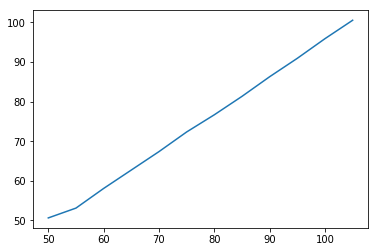

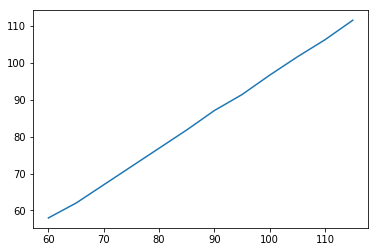

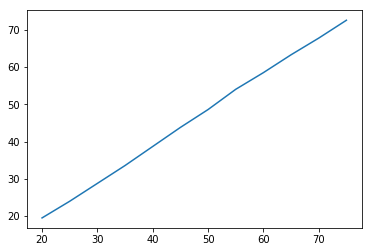

In [123]:
def find_linear_mappings(servo_dict, arm):
    """
    {servo_enum: starting_angle}
    """
    def reset():
        for servo, start_angle in servo_dict.items():
            arm.set_servo_angle(servo, start_angle)
    res = dict()
    for servo, start_angle in servo_dict.items():
        reset()
        sleep(1)
        res[servo] = dict()
        commanded, measured = command_and_measure(servo, start_angle, arm)
        plt.plot(commanded, measured)
        plt.show()
        regr_res = linregress(commanded, measured)
        res[servo]['slope'] = regr_res.slope
        res[servo]['intercept'] = regr_res.intercept

        # define function that collects data points for any servo

        # calculate forward and inverse functions for angle mappings
    return res
    
linear_maps = find_linear_mappings({
    SERVO_BOTTOM: 50,
    SERVO_LEFT: 60,
    SERVO_RIGHT: 20
}, arm)

In [122]:
attach_all()

In [124]:
linear_maps

{0: {'intercept': 2.6908041958041764, 'slope': 0.92869930069930084},
 1: {'intercept': -1.6037179487179429, 'slope': 0.98246153846153839},
 2: {'intercept': -0.29324009324009381, 'slope': 0.97655944055944055}}

In [54]:
# TODO:
# 1, collect data
# 2, find mapping
# 3, find mapping from cartesian to real to commanded
servo_angles.append((list(map(to_deg, inverse(0, 0.30, 0)))[0], arm.get_servo_angle(SERVO_LEFT)))

NameError: name 'servo_angles' is not defined

In [918]:
def coord_generator():
    coords = [
        [-0.10, 0.10],
        [-0.10, 0.125],
        [-0.10, 0.15],
        [-0.05, 0.20],
        [ 0.00, 0.225],
        [ 0.00, 0.25],
        [ 0.05, 0.25],
        [ 0.10, 0.30],
    ]
    for x, y in coords:
        yield x, y
    
coords = coord_generator()
res = np.zeros((8, 5))
i = 0
detach_all()

In [926]:
x, y = next(coords)
res[i, :] = [
    x,
    y,
    arm.get_servo_angle(SERVO_BOTTOM),
    arm.get_servo_angle(SERVO_LEFT),
    arm.get_servo_angle(SERVO_RIGHT)
]
i += 1

In [927]:
gamma_maps = []
beta_maps = []
alpha_maps = []
for x, y, bottom, left, right in res:
    alpha_hat, beta_hat, gamma_hat = list(map(to_deg, inverse(x, y, 0.0)))
    gamma_maps.append((gamma_hat, bottom))
    alpha_maps.append((alpha_hat, left))
    beta_maps.append((beta_hat, right))
gamma_maps = np.array(gamma_maps)
alpha_maps = np.array(alpha_maps)
beta_maps = np.array(beta_maps)

In [928]:
servo_angle_pairs = [
    (SERVO_LEFT, alpha_maps),
    (SERVO_RIGHT, beta_maps),
    (SERVO_BOTTOM, gamma_maps),
]
angle_maps = dict()
for servo, angles in servo_angle_pairs:
    r = linregress(angles[:, 0], angles[:, 1])
    angle_maps[servo] = {
        'intercept': r.intercept,
        'slope': r.slope,
    }
angle_maps, SERVO_RIGHT

({0: {'intercept': 4.0613201855793477, 'slope': 0.96219542301315297},
  1: {'intercept': 56.29393322309528, 'slope': 1.0913962586461741},
  2: {'intercept': 26.701744661457084, 'slope': -1.0710567168423992}},
 2)

In [931]:
#uarm_params = {
#    'commanded_measured': linear_maps,
#    'ideal_real': angle_maps
#}
#a._uarm_params['ideal_real'] = angle_maps
#uarm_params = a._uarm_params
with open('uarm_params.pkl', 'wb') as f:
    pickle.dump(uarm_params, f)
uarm_params

{'commanded_measured': {0: {'intercept': -2.6, 'slope': 1.074783216783217},
  1: {'intercept': -5.3, 'slope': 1.0619090909090909},
  2: {'intercept': -4.0, 'slope': 1.0777202797202796}},
 'ideal_real': {0: {'intercept': 4.0613201855793477,
   'slope': 0.96219542301315297},
  1: {'intercept': 56.29393322309528, 'slope': 1.0913962586461741},
  2: {'intercept': 26.701744661457084, 'slope': -1.0710567168423992}}}

In [972]:
a.disconnect()

pyuarm - INFO - Disconnect from port - /dev/cu.usbserial-AI04HYRU...
pyuarm - INFO - Disconnect from port - /dev/cu.usbserial-AI04HYRU...
pyuarm - INFO - Disconnect from port - /dev/cu.usbserial-AI04HYRU...
